In [30]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from get_metrics1 import get_metrics_classification
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from lightgbm import LGBMClassifier, early_stopping
import shap
import optuna
from get_metrics1 import get_metrics_classification
from sklearn.inspection import permutation_importance
from SupFunctions import barplot_group, barplot_balance, check_overfitting_classification, check_overfitting_multiclass, scale_pos_weight_calc
from sklearn.inspection import permutation_importance
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10
N_FOLD = 5

In [4]:
df_credit = pd.read_csv('df_credit.csv')

In [5]:
meta_X = pd.read_csv('meta_X_final.csv')

In [6]:
meta_X_test = pd.read_csv('meta_X_test_final.csv')

In [7]:
meta_X = meta_X.set_index('index')

In [8]:
meta_X_test = meta_X_test.set_index('index')

In [9]:
df_metrics = pd.read_csv('models_metrics_final.csv')

In [10]:
df_credit.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [11]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44961 entries, 0 to 44960
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44961 non-null  float64
 1   person_gender                   44961 non-null  object 
 2   person_education                44961 non-null  object 
 3   person_income                   44961 non-null  float64
 4   person_emp_exp                  44961 non-null  int64  
 5   person_home_ownership           44961 non-null  object 
 6   loan_amnt                       44961 non-null  float64
 7   loan_intent                     44961 non-null  object 
 8   loan_int_rate                   44961 non-null  float64
 9   loan_percent_income             44961 non-null  float64
 10  cb_person_cred_hist_length      44961 non-null  float64
 11  credit_score                    44961 non-null  int64  
 12  previous_loan_defaults_on_file  

In [12]:
df_metrics

,model,Accuracy,ROC_AUC,Logloss,Precision,Recall,f1
0,Catboost baseline Holdout,0.930390,0.977312,0.153096,0.889835,0.783892,0.833511
1,LightGBM baseline Holdout,0.932948,0.978504,0.149401,0.903468,0.781891,0.838294
2,LightGBM best_params optuna Holdout,0.921383,0.969897,0.177029,0.881346,0.746873,0.808557
3,LightGBM best_params RS Holdout,0.934282,0.979919,0.144769,0.906936,0.784892,0.841512
4,Catboost RS Holdout,0.939175,0.980601,0.142082,0.902886,0.813907,0.856091


In [32]:
df_credit = df_credit.astype({col: 'category' for col in df_credit.select_dtypes(include='object').columns})

In [33]:
X = df_credit.drop(['loan_status'], axis=1)
y = df_credit['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y, 
                                                    random_state=RAND)

In [15]:
final_clf = LogisticRegression(random_state=RAND)
final_clf.fit(meta_X, y_train)

LogisticRegression(random_state=10)

In [16]:
y_pred_final = final_clf.predict(meta_X_test)
y_proba_final = final_clf.predict_proba(meta_X_test)

y_proba_train = final_clf.predict_proba(meta_X)

In [17]:
check_overfitting_classification(final_clf,
                  meta_X,
                  y_train,
                  meta_X_test,
                  y_test)

ROC-AUC train: 0.978
ROC-AUC test: 0.981
delta = 0.3 %


(0.9781226815681542, 0.9806039708444442, 0.25303683750670863)

In [18]:
df_metrics = pd.concat([df_metrics, get_metrics_classification(y_test, y_pred_final, y_proba_final, 'Stacking LogisticRegression')], axis=0)
df_metrics

,model,Accuracy,ROC_AUC,Logloss,Precision,Recall,f1
0,Catboost baseline Holdout,0.930390,0.977312,0.153096,0.889835,0.783892,0.833511
1,LightGBM baseline Holdout,0.932948,0.978504,0.149401,0.903468,0.781891,0.838294
2,LightGBM best_params optuna Holdout,0.921383,0.969897,0.177029,0.881346,0.746873,0.808557
3,LightGBM best_params RS Holdout,0.934282,0.979919,0.144769,0.906936,0.784892,0.841512
4,Catboost RS Holdout,0.939175,0.980601,0.142082,0.902886,0.813907,0.856091
0,Stacking LogisticRegression,0.937729,0.980604,0.161078,0.902630,0.806903,0.852087


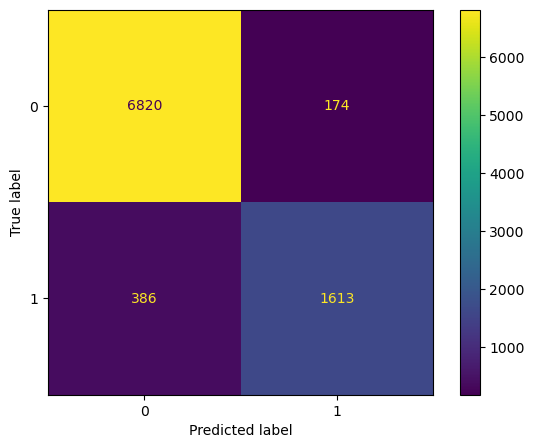

In [19]:
def plot_confusion_matrix(y_true, y_pred, ax=None):
    """Визуализация ConfusionMatrix"""
    labels = list(set(y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax:
        disp.plot(ax=ax)
    else:
        disp.plot()

# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(7, 5))

# Визуализируем матрицу ошибок
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_final, ax=ax)
plt.show()

Для анализа полей воспользуемся моделью LightGBM c параметрами, подобранными при помощи Optuna

In [21]:
best_params = {'n_estimators': 312,
 'learning_rate': 0.030152305383741834,
 'num_leaves': 580,
 'max_depth': 12,
 'min_child_samples': 500,
 'reg_alpha': 42,
 'reg_lambda': 53,
 'min_split_gain': 14,
 'subsample': 0.8533106326801126,
 'subsample_freq': 1,
 'colsample_bytree': 0.8000931922087815,
 'random_state': 10,
 'is_unbalance': True}

In [25]:
lgbm_optuna = LGBMClassifier(**best_params, objective='binary', verbose=-1)

In [34]:
def objective_lgb(trial, X, y, N_FOLDS, random_state):
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)
    cv_predicts = np.empty(N_FOLDS)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_params = {
            "random_state": random_state,
            "verbosity": -1,
            "boosting_type": "gbdt",
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_samples": trial.suggest_int("min_child_samples", 100, 70000, step=100),
            "reg_alpha": trial.suggest_int("reg_alpha", 0, 100),
            "reg_lambda": trial.suggest_int("reg_lambda", 0, 100),
            "min_split_gain": trial.suggest_int("min_split_gain", 0, 20),
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            "random_state": trial.suggest_categorical("random_state", [random_state]),
            "is_unbalance": trial.suggest_categorical("is_unbalance", [True])
    }
        
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
        model = LGBMClassifier(verbose=-1, **lgb_params)
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="auc",
            callbacks=[pruning_callback, early_stopping(stopping_rounds=100)]
        )
        
        preds = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_test, preds)
    
    return np.mean(cv_predicts)

In [35]:
study_lgb = optuna.create_study(direction="maximize", study_name="LGB_01")
func = lambda trial: objective_lgb(
    trial, X_train, y_train, N_FOLDS=N_FOLD, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.ERROR)
study_lgb.optimize(func, n_trials=20, show_progress_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.529764
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.529764
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.529938
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.529803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.529803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5	valid_0's binary_logloss: 0.529764
Training until validation scores don't improve for 100 rounds
Early st

In [37]:
study_lgb.best_params

{'n_estimators': 572,
 'learning_rate': 0.06760630641790481,
 'num_leaves': 660,
 'max_depth': 4,
 'min_child_samples': 200,
 'reg_alpha': 61,
 'reg_lambda': 57,
 'min_split_gain': 12,
 'subsample': 0.7035973923914469,
 'subsample_freq': 1,
 'colsample_bytree': 0.6997401409814812,
 'random_state': 10,
 'is_unbalance': True}

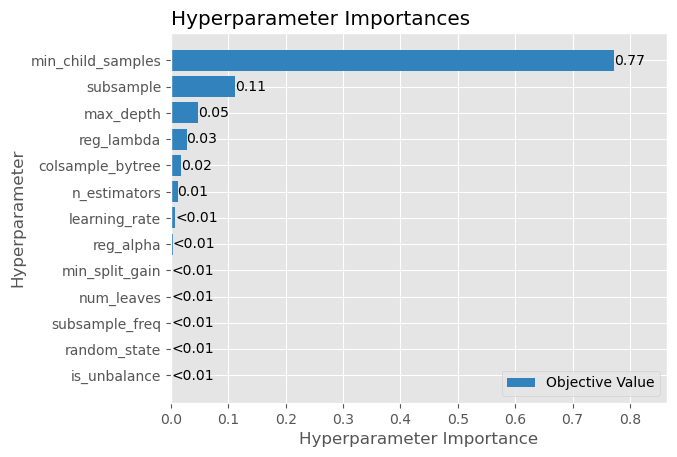

In [38]:
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

plot_param_importances(study_lgb);

По анализу от optuna можно выделить три параметра, которые в большей степени влияют на модель:
1) min_child_samples: минимальное количество объектов, которое должно находиться в одном листе дерева
2) subsample: доля случайно выбираемых объектов для обучения каждого дерева.
3) max_depth: максимальная глубина дерева

In [45]:
cat_features = list(df_credit.select_dtypes(include=['category']).columns)

In [46]:
X_train_encoded = pd.get_dummies(X_train, columns=cat_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_features, drop_first=True)

In [47]:
lgbm_optuna = LGBMClassifier(**best_params, objective='binary', verbose=-1)
lgbm_optuna.fit(X_train_encoded, y_train, eval_metric='logloss') 

LGBMClassifier(colsample_bytree=0.8000931922087815, is_unbalance=True,
               learning_rate=0.030152305383741834, max_depth=12,
               min_child_samples=500, min_split_gain=14, n_estimators=312,
               num_leaves=580, objective='binary', random_state=10,
               reg_alpha=42, reg_lambda=53, subsample=0.8533106326801126,
               subsample_freq=1, verbose=-1)

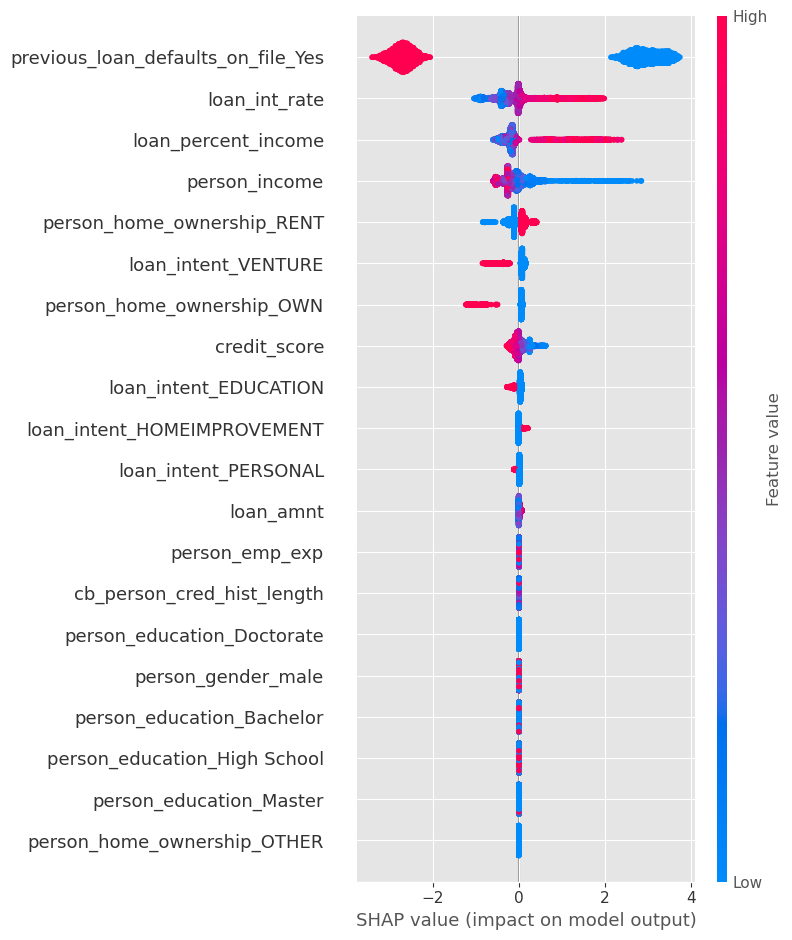

In [51]:
# 1. Создание explainer с корректными параметрами
explainer = shap.TreeExplainer(
    model=lgbm_optuna,
    feature_perturbation="tree_path_dependent",  # Обязательно для LightGBM
    model_output="raw"  # Должно быть "raw" для tree_path_dependent
)

# 2. Получение SHAP значений
shap_values = explainer.shap_values(X_test_encoded)

# 3. Визуализация
shap.summary_plot(shap_values, X_test_encoded)